In [1]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT/"src"))

# Startup checks
from startup_checks import ensure_project_dirs, check_required_artifacts
ensure_project_dirs()
# Tuning requires preprocessing artifacts (tokenizer and label map) only
check_required_artifacts(require_model=False, require_weights=False)

2025-12-19 17:12:23.305596: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-19 17:12:23.361254: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


All required artifacts are found. Notebook is ready


2025-12-19 17:12:24.449725: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
from config import TEXT_COL, LABEL_COL, TUNING_MODELS_DIR, CLEAN_FILE, RANDOM_STATE, VOCAB_SIZE, MAX_LEN, BEST_WEIGHT_FILE
from preprocess import load_and_clean_data, text_to_padded_sequences
from artifacts_utils import load_label_artifacts, load_tokenizer, save_best_model_metadata, save_latest_metrics
from utils import reset_tf_state, encode_labels, generate_config_name, evaluate_and_plot, clear_folder
from models import build_bilstm_model

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score

import numpy as np
import pandas as pd

In [3]:
# Clear tuning folder
clear_folder(TUNING_MODELS_DIR, verbose=True)

In [4]:
# Load dataset and label artifacts
df = load_and_clean_data(CLEAN_FILE, basic_clean=False, clean_label=False)    # Load clean file built in Notebook 01
label_order, label_to_id, id_to_label = load_label_artifacts()    # Load label aritfacts built in Notebook 02
X = df[TEXT_COL].values
y_encoded = encode_labels(df[LABEL_COL].values, label_to_id)

In [5]:
# Split dataset into train, validation and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    stratify=y_encoded,
    test_size=0.15,    # train 85% | test 15%
    random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    stratify=y_train,
    test_size=0.15/0.85,    # train ~70% | validation ~15%
    random_state=RANDOM_STATE
)

In [6]:
# Load tokenizer
tokenizer = load_tokenizer()

# Preprocess sequences
X_train_pad, X_train_seq = text_to_padded_sequences(tokenizer, X_train, MAX_LEN)
X_val_pad, X_val_seq = text_to_padded_sequences(tokenizer, X_val, MAX_LEN)
X_test_pad, X_test_seq = text_to_padded_sequences(tokenizer, X_test, MAX_LEN)

In [7]:
# Compute class weights due to imbalanced dataset
classes = np.unique(y_train)

class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)

class_weights = dict(zip(classes, class_weights_array))
class_weights

{np.int32(0): np.float64(1.051440329218107),
 np.int32(1): np.float64(2.2635658914728682),
 np.int32(2): np.float64(0.6222222222222222)}

In [8]:
# Configure hyperparameters
hyperparams_configs = [
    {    # 0
        "embedding_dim": 100,
        "lstm_units": 64,
        "dropout": 0.4,
        "lr": 1e-3,
        "dense_units": 64,
        "dense_dropout": 0.2,
        "batch_size": 64,
    },
    {    # 1
        "embedding_dim": 100,
        "lstm_units": 64,
        "dropout": 0.3,
        "lr": 5e-4,
        "dense_units": 64,
        "dense_dropout": 0.2,
        "batch_size": 32,        
    },       
    {    # 2
        "embedding_dim": 100,
        "lstm_units": 32,
        "dropout": 0.2,
        "lr": 5e-4,
        "dense_units": 64,
        "dense_dropout": 0.2,
        "batch_size": 32,
    },
    {    # 3
        "embedding_dim": 64,
        "lstm_units": 128,
        "dropout": 0.5,
        "lr": 5e-4,
        "dense_units": 64,
        "dense_dropout": 0.2,
        "batch_size": 32,
    },
    {    # 4
        "embedding_dim": 64,
        "lstm_units": 64,
        "dropout": 0.3,
        "lr": 1e-3,
        "dense_units": 64,
        "dense_dropout": 0.3,
        "batch_size": 32,        
    },
    {    # 5
        "embedding_dim": 64,
        "lstm_units": 32,
        "dropout": 0.2,
        "lr": 5e-4,
        "dense_units": 64,
        "dense_dropout": 0.2,
        "batch_size": 32,        
    }
]

cbs_cfg = []

# Configure callback paramters
es_cb_cfg = {
    "name": "EarlyStopping",
    "monitor": "val_loss",
    "patience": 4,
    "restore_best_weights": True    
}

cbs_cfg.append(es_cb_cfg)

# Generate cfg names based on fields provided
fields = ["embedding_dim", "lstm_units", "dropout", "lr", "dense_units", "dense_dropout", "batch_size"]
epochs = 30

for cfg in hyperparams_configs:
    cfg["name"] = generate_config_name(cfg, fields)
    cfg["epochs"] = epochs

print(f"Total configuration: {len(hyperparams_configs)}")

Total configuration: 6


In [9]:
# Tuning
results = []

for idx, cfg in enumerate(hyperparams_configs):
    cfg_name = cfg["name"]
    print(f"Training #{idx} {cfg_name}")
    
    reset_tf_state(RANDOM_STATE)    # Avoid memory accumulation during tuning
    
    # Build the biLSTM model with corresponding hyperparamter_config
    model = build_bilstm_model(
        cfg,
        vocab_size=VOCAB_SIZE,
        max_len=MAX_LEN,
        classes_qty=len(label_order)
    )

    # Save weights for each cfg
    save_weights = True
    ext = ".weights.h5" if save_weights else ".keras"
    weight_path = TUNING_MODELS_DIR / f"bilstm_{cfg_name}{ext}"
    
    checkpoint_cb = ModelCheckpoint(
        weight_path,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=save_weights,
        verbose=False
    )
    
    # Train the model
    es = EarlyStopping(
        monitor=es_cb_cfg["monitor"],
        patience=es_cb_cfg["patience"],
        restore_best_weights=es_cb_cfg["restore_best_weights"]
    )
    
    history = model.fit(
        X_train_pad, y_train,
        validation_data=(X_val_pad, y_val),
        epochs=cfg["epochs"],
        batch_size=cfg["batch_size"],
        class_weight=class_weights,
        callbacks=[checkpoint_cb, es]
    )
    
    # Evaluate
    val_loss, val_acc = model.evaluate(X_val_pad, y_val, verbose=0)
    y_pred = model.predict(X_val_pad, verbose=0).argmax(axis=1)
    val_f1 = f1_score(y_val, y_pred, average="macro")
    
    # Store results
    results.append({
        "name": cfg_name,
        "val_f1": val_f1,
        "val_acc": val_acc,
        "val_loss": val_loss,
        "weights_path": weight_path
    })
    

Training #0 h_emb100_lst64_dro04_lr1e-3_den64_den02_bat64


I0000 00:00:1766135545.157884   62441 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/30


2025-12-19 17:12:29.397823: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.4332 - loss: 1.0668 - val_accuracy: 0.5074 - val_loss: 0.9659
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6803 - loss: 0.7926 - val_accuracy: 0.6682 - val_loss: 0.7842
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8351 - loss: 0.3966 - val_accuracy: 0.6830 - val_loss: 0.9243
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8931 - loss: 0.2365 - val_accuracy: 0.6408 - val_loss: 0.9826
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9112 - loss: 0.1939 - val_accuracy: 0.6374 - val_loss: 1.2191
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9166 - loss: 0.1618 - val_accuracy: 0.6385 - val_loss: 1.4811
Training #1 h_emb100_lst64_dro03_lr5e-4_den64_den02_bat32
Epoch 1/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.4327 - loss: 1.0674 - val_accuracy: 0.5735 - val_loss: 0.9402
Epoch 2/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy

In [10]:
# List the result
results_df = pd.DataFrame(results).sort_values(by="val_f1", ascending=False)
display(results_df)

results_df.to_csv(TUNING_MODELS_DIR/"tuning_results.csv", index=False)    # Save the tuning results

,name,val_f1,val_acc,val_loss,weights_path
5,h_emb64_lst32_dro02_lr5e-4_den64_den02_bat32,0.632397,0.677309,0.834235,/home/tl/stock-news-sentiment-tensorflow/artif...
4,h_emb64_lst64_dro03_lr1e-3_den64_den03_bat32,0.618842,0.660205,0.813597,/home/tl/stock-news-sentiment-tensorflow/artif...
2,h_emb100_lst32_dro02_lr5e-4_den64_den02_bat32,0.613257,0.670467,0.803157,/home/tl/stock-news-sentiment-tensorflow/artif...
0,h_emb100_lst64_dro04_lr1e-3_den64_den02_bat64,0.600910,0.668187,0.784184,/home/tl/stock-news-sentiment-tensorflow/artif...
1,h_emb100_lst64_dro03_lr5e-4_den64_den02_bat32,0.599282,0.640821,0.832122,/home/tl/stock-news-sentiment-tensorflow/artif...
3,h_emb64_lst128_dro05_lr5e-4_den64_den02_bat32,0.596473,0.649943,0.872942,/home/tl/stock-news-sentiment-tensorflow/artif...


In [11]:
# Save hyperparameters and metrics
best_row = results_df.iloc[0]
best_cfg = next(c for c in hyperparams_configs if c["name"] == best_row["name"])

#print("Best config:", best_cfg)

best_metrics = {
    "name": best_row["name"],
    "val_f1": float(best_row["val_f1"]),
    "val_acc": float(best_row["val_acc"]),
    "val_loss": float(best_row["val_loss"]),
    "weights_path": str(best_row["weights_path"])
}

save_best_model_metadata(best_cfg, cbs_cfg, best_metrics)

Model parameters are saved in /home/tl/stock-news-sentiment-tensorflow/artifacts/results/best_model_metadata.json


In [12]:
# Build the best model
reset_tf_state(RANDOM_STATE)

best_model = build_bilstm_model(
    best_cfg,
    vocab_size=VOCAB_SIZE,
    max_len=MAX_LEN,
    classes_qty=len(label_order)
)

best_model.load_weights(best_row["weights_path"])
best_model.save_weights(BEST_WEIGHT_FILE)

/home/tl/stock-news-sentiment-tensorflow/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


----------------- Metrics -----------------
 val_macro_f1  val_acc  val_loss
     0.632397 0.677309  0.834235
-------------------------------------------

              precision    recall  f1-score   support

    positive       0.68      0.76      0.72       278
    negative       0.40      0.52      0.45       129
     neutral       0.79      0.67      0.73       470

    accuracy                           0.68       877
   macro avg       0.62      0.65      0.63       877
weighted avg       0.70      0.68      0.68       877



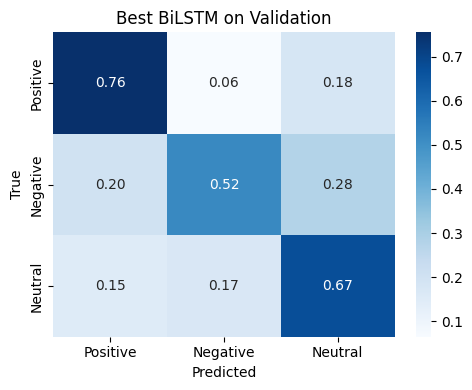

Best model: val_loss = 0.8342, val_acc = 0.6773


In [13]:
# Evaluate best model of validation set
val_metrics = evaluate_and_plot(best_model, X_val_pad, y_val, label_order, split_name="val", title="Best BiLSTM on Validation")

print(f"Best model: val_loss = {val_metrics['val_loss']:.4f}, val_acc = {val_metrics['val_acc']:.4f}")

In [14]:
notebook_name = "03_bilstm_hyperparameter_tuning"

# Save validation metrics to artifacts/result
val_metrics["split"] = "val"
val_metrics["model"] = "BiLSTM"
val_metrics["stage"] = "03-BiLSTM Hyperparameter Tuning"

save_latest_metrics(
    metrics=val_metrics,
    filename=f"{notebook_name}_validation"
)

Metrics are saved in /home/tl/stock-news-sentiment-tensorflow/artifacts/results/03_bilstm_hyperparameter_tuning_validation.json


## Summary - Hyperparameter Tuning and Model Selection

### Objective
Systematically improve the BiLSTM model through controlled hyperparameter tuning.

### Work performed
- Loaded preprocessing artifacts from the baseline model (tokenizer and label mappings)
- Defined a structured hyperparameter search space covering:
  - Embedding dimension
  - LSTM units
  - Dropout rates
  - Learning rate and batch size
- Trained multiple model configurations with clean session resets between runs
- Tracked validation metrics and saved results for comparison

### Key decisions
- Model selection based on **validation macro F1-score**
- Best-performing model weights and configurations are persisted for final evaluation

### Results
- **Best macro F1-score (validation)**: Automatically saved in **artifacts/results/03_bilstm_hyperparameter_tuning_validation.json**

### Artifacts produced
- Best hyperparameters and training settings are saved in **artifacts/results/best_model_metadata.json**
- Best model weights are saved as **artifacts/models/best/bilstm_best_weight.weights.h5**
- Validation metrics (best config)

### Takeaway
Hyperparameter tuning yields a modest but consistent improvement over the baseline BiLSTM, confirming that careful configuration can enhance performance without overfitting.